<a href="https://colab.research.google.com/github/Berengarius13/Spam_Detection_LSTM/blob/main/Spam_Detection_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D #, Bidirectional
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load Data

In [2]:
df = pd.read_csv('Datasets/spam.csv', encoding='ISO-8859-1')

In [3]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


# Data Preprocessing

In [4]:
df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1, inplace=True)

In [5]:
df.head(6)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...


In [6]:
df.columns = ['labels', 'data']

In [7]:
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Create Binary Labels

In [8]:
X = df['data']
df['b_labels'] = df['labels'].map({'ham' : 0, 'spam' : 1})
y = df['b_labels'].values
print(df['data'])
print(y)

0       Go until jurong point, crazy.. Available only ...
1                           Ok lar... Joking wif u oni...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor... U c already then say...
4       Nah I don't think he goes to usf, he lives aro...
                              ...                        
5567    This is the 2nd time we have tried 2 contact u...
5568                Will Ì_ b going to esplanade fr home?
5569    Pity, * was in mood for that. So...any other s...
5570    The guy did some bitching but I acted like i'd...
5571                           Rofl. Its true to its name
Name: data, Length: 5572, dtype: object
[0 0 1 ... 0 0 0]


In [9]:
# Get all the ham and spam emails
ham_messages = df[df.labels == 'ham']
spam_messages = df[df.labels == 'spam']

# Create numpy list to visualize using wordcloud
ham_msg_text = " ".join(ham_messages.data.to_numpy().tolist())
spam_msg_text = " ".join(spam_messages.data.to_numpy().tolist())



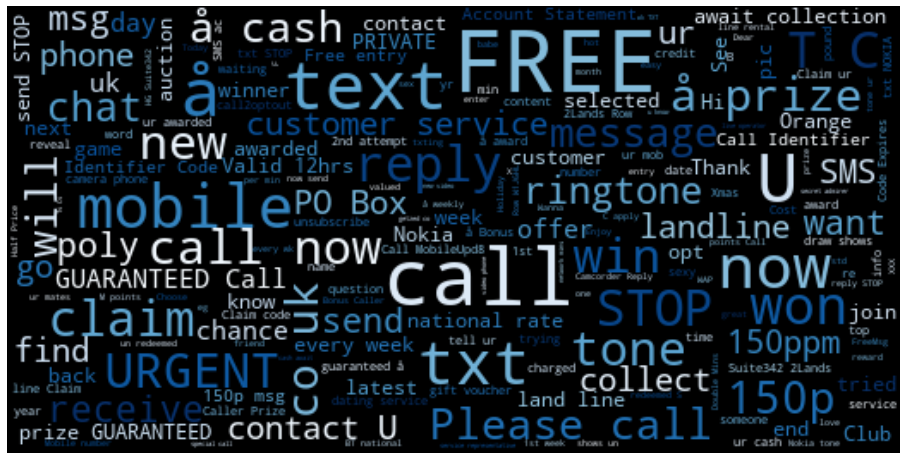

In [10]:
# wordcloud of spam messages
ham_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(spam_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

## Train Test Split

In [11]:
df_train, df_test, y_train, y_test = train_test_split(df['data'], y, test_size=0.33) 

## Preprocessing for Embedding

In [12]:
# Convert sentences to sequences
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)

# Get sequences of integers for each sentence
sequences_train = tokenizer.texts_to_sequences(df_train) 
sequences_test = tokenizer.texts_to_sequences(df_test)

In [13]:
# word integer mapping
word2idx = tokenizer.word_index # word integer pairs
V = len(word2idx)
print("Tokens found: ", V)

Tokens found:  7298


## Reshape Data for NN

In [14]:
# Need N x T matrix (can substitute D for T)
X_train = pad_sequences(sequences_train) # Pad sequences to make them of equal length
print("Train Sensor shape: ", X_train.shape)

T = X_train.shape[1]
print("Sequence length: ", T)

X_test = pad_sequences(sequences_test, maxlen=T)
print("Test Sensor shape: ", X_test.shape)

Train Sensor shape:  (3733, 189)
Sequence length:  189
Test Sensor shape:  (1839, 189)


# Build Model

In [15]:
N = df.shape[0] # Number of sequences
# T, the sequence length has been defined
D = 25 # Embedding dimensionality is a hyperparameter, because you get to choose any word vector sizez you want
M = 30 # Number of neurons per hidden layer

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i) # output dimensions are (V + 1, D) because embedding index starts at 1
x = LSTM(M, return_sequences=True)(x) # Bidirectional()
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)

model.compile(optimizer=Adam(learning_rate =0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [16]:
r = model.fit(X_train, y_train,
              validation_data = (X_test, y_test),
              epochs = 20)

Epoch 1/20
117/117 [==============================] - 7s 45ms/step - loss: 0.4565 - accuracy: 0.8540 - val_loss: 0.3754 - val_accuracy: 0.8760
Epoch 2/20
117/117 [==============================] - 5s 43ms/step - loss: 0.3996 - accuracy: 0.8610 - val_loss: 0.3631 - val_accuracy: 0.8760
Epoch 3/20
117/117 [==============================] - 5s 43ms/step - loss: 0.3269 - accuracy: 0.8610 - val_loss: 0.2532 - val_accuracy: 0.8760
Epoch 4/20
117/117 [==============================] - 5s 45ms/step - loss: 0.2219 - accuracy: 0.8612 - val_loss: 0.1829 - val_accuracy: 0.9038
Epoch 5/20
117/117 [==============================] - 5s 45ms/step - loss: 0.1421 - accuracy: 0.9772 - val_loss: 0.1233 - val_accuracy: 0.9772
Epoch 6/20
117/117 [==============================] - 5s 43ms/step - loss: 0.0849 - accuracy: 0.9871 - val_loss: 0.0922 - val_accuracy: 0.9831
Epoch 7/20
117/117 [==============================] - 5s 43ms/step - loss: 0.0534 - accuracy: 0.9906 - val_loss: 0.0752 - val_accuracy: 0.9837

# Evaluate Model

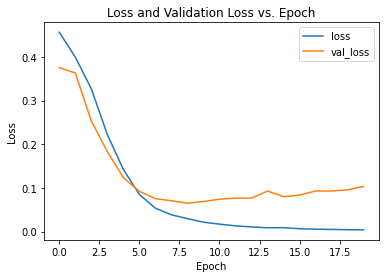

In [17]:
# Plot the loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.title("Loss and Validation Loss vs. Epoch")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

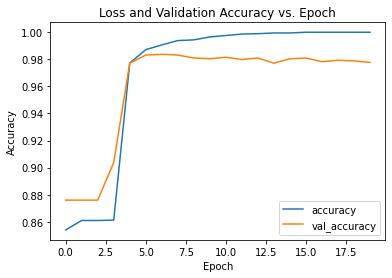

In [18]:
# Plot the loss
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.title("Loss and Validation Accuracy vs. Epoch")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

In [19]:
predict_msg = ["Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",
          "Ok lar... Joking wif u oni...",
          "Gear up and start stretching those creative muscles - this week’s #CanvaDesignChallenge is all about Sports. Design anything inspired by a Sport of your choice - or two, or three, it’s totally up to you. Add elements and illustrations inspired by ball sports like tennis or golf. Use photos featuring outdoor activities like biking or archery. You can even take inspiration from sporty hobbies like surfing or swimming - anything you want as long as it’s about Sports. Give it your best shot, share your design with us, and you could win a Canva prize pack."]


In [20]:
# Prediction Function

def predict_spam(predict_msg):
    new_seq = tokenizer.texts_to_sequences(predict_msg)
    padded = pad_sequences(new_seq, maxlen= T)
    return model.predict(padded)



In [21]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [23]:
model.save("my_model.h5")